# Feature Selection

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="ticks")

import scipy.stats as ss
from collections import Counter
import math 
from scipy import stats

In [31]:
# seaborn dataset names
print(sns.get_dataset_names())

['anscombe', 'attention', 'brain_networks', 'car_crashes', 'diamonds', 'dots', 'exercise', 'flights', 'fmri', 'gammas', 'iris', 'mpg', 'planets', 'tips', 'titanic']


/Users/mengwangk/anaconda3/lib/python3.7/site-packages/seaborn/utils.py:376: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 376 of the file /Users/mengwangk/anaconda3/lib/python3.7/site-packages/seaborn/utils.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  gh_list = BeautifulSoup(http)


## Dataset

In [173]:
tips = sns.load_dataset("tips")
#tips["tip"] = pd.to_numeric(tips["tip"])
tips.head(10)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2


In [174]:
tips["total_bill_cut"] = pd.cut(tips["total_bill"],
                                np.arange(0, 60, 5),
                                include_lowest=True,
                                right=False)

In [175]:
tips.dtypes

total_bill         float64
tip                float64
sex               category
smoker            category
day               category
time              category
size                 int64
total_bill_cut    category
dtype: object

In [176]:
tips.head(10)

,total_bill,tip,sex,smoker,day,time,size,total_bill_cut
0,16.99,1.01,Female,No,Sun,Dinner,2,"[15, 20)"
1,10.34,1.66,Male,No,Sun,Dinner,3,"[10, 15)"
2,21.01,3.50,Male,No,Sun,Dinner,3,"[20, 25)"
3,23.68,3.31,Male,No,Sun,Dinner,2,"[20, 25)"
4,24.59,3.61,Female,No,Sun,Dinner,4,"[20, 25)"
5,25.29,4.71,Male,No,Sun,Dinner,4,"[25, 30)"
6,8.77,2.00,Male,No,Sun,Dinner,2,"[5, 10)"
7,26.88,3.12,Male,No,Sun,Dinner,4,"[25, 30)"
8,15.04,1.96,Male,No,Sun,Dinner,2,"[15, 20)"
9,14.78,3.23,Male,No,Sun,Dinner,2,"[10, 15)"


In [177]:
tips['size'].unique()

array([2, 3, 4, 1, 6, 5])

In [178]:
len(tips)

244

### Preprocessing

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [76]:
# Check incomplete rows
incomplete_rows = tips[tips.isnull().any(axis=1)].head()
incomplete_rows

,total_bill,tip,sex,smoker,day,time,size,total_bill_cut


In [108]:
num_attrs = [""]
cat_attrs = list(tips.drop(["total_bill", "tip"], axis=1))
num_attrs, cat_attrs

([''], ['sex', 'smoker', 'day', 'time', 'size', 'total_bill_cut'])

In [181]:
labels = tips["tip"].astype("float64")

In [79]:
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])
cat_pipeline = num_pipeline = Pipeline([
       ("cat", OneHotEncoder(categories='auto'))
    ])

In [80]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attrs),
        ("cat", cat_pipeline, cat_attrs),
    ])
tips_preprocessed = full_pipeline.fit_transform(tips)

In [84]:
tips_preprocessed.shape

(244, 27)

In [87]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

In [90]:
len(labels)

244

### Cramer

In [34]:
# https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

confusion_matrix = pd.crosstab(tips["day"], tips["time"]).values
cramers_v(confusion_matrix)
# Out[10]: 0.93866193407222209

confusion_matrix = pd.crosstab(tips["total_bill_cut"], tips["time"]).values
cramers_v(confusion_matrix)

# Out[24]: 0.16498707494988371

0.1649870749498837

In [35]:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confaausion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

## Theils U

In [15]:
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

## Correlation Ratio

In [16]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

### Preprocessing

In [109]:
# df = pd.concat([ tips[num_attrs] + pd.get_dummies(tips[cat_attrs]) ], axis=1)
df = pd.concat([ pd.get_dummies(tips[cat_attrs]) ], axis=1)
df.shape, df.columns

((244, 22),
 Index(['size', 'sex_Male', 'sex_Female', 'smoker_Yes', 'smoker_No', 'day_Thur',
        'day_Fri', 'day_Sat', 'day_Sun', 'time_Lunch', 'time_Dinner',
        'total_bill_cut_[0, 5)', 'total_bill_cut_[5, 10)',
        'total_bill_cut_[10, 15)', 'total_bill_cut_[15, 20)',
        'total_bill_cut_[20, 25)', 'total_bill_cut_[25, 30)',
        'total_bill_cut_[30, 35)', 'total_bill_cut_[35, 40)',
        'total_bill_cut_[40, 45)', 'total_bill_cut_[45, 50)',
        'total_bill_cut_[50, 55)'],
       dtype='object'))

In [113]:
df.head(2)

,size,sex_Male,sex_Female,smoker_Yes,smoker_No,day_Thur,day_Fri,day_Sat,day_Sun,time_Lunch,...,"total_bill_cut_[5, 10)","total_bill_cut_[10, 15)","total_bill_cut_[15, 20)","total_bill_cut_[20, 25)","total_bill_cut_[25, 30)","total_bill_cut_[30, 35)","total_bill_cut_[35, 40)","total_bill_cut_[40, 45)","total_bill_cut_[45, 50)","total_bill_cut_[50, 55)"
0,2,0,1,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,3,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [132]:
type(labels)

pandas.core.series.Series

In [133]:
#labels = pd.DataFrame(labels)

## Pearson Correlation

$$\frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})} {\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2(y_i - \overline{y})^2}}$$

In [92]:
# Number of features to select
num_features = 8

In [17]:
# https://www.kaggle.com/mlwhiz/feature-selection-using-football-data

In [134]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [182]:
cor_support, cor_feature = cor_selector(df, labels, num_features)

In [183]:
print(str(len(cor_feature)), 'selected features')

8 selected features


In [184]:
cor_feature

['total_bill_cut_[35, 40)',
 'total_bill_cut_[30, 35)',
 'total_bill_cut_[5, 10)',
 'total_bill_cut_[25, 30)',
 'total_bill_cut_[45, 50)',
 'total_bill_cut_[50, 55)',
 'total_bill_cut_[10, 15)',
 'size']

## Chi-Squared

In [185]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [186]:
df_norm = MinMaxScaler().fit_transform(df)

/Users/mengwangk/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [233]:
chi_selector = SelectKBest(chi2, k=num_features)
chi_selector, df_norm.shape, labels.shape

(SelectKBest(k=8, score_func=<function chi2 at 0x1a1fb12ea0>),
 (244, 22),
 (244,))

In [242]:
chi_selector.fit(df_norm, labels.astype('int'))
#chi_selector.fit?
#SelectKBest?

SelectKBest(k=8, score_func=<function chi2 at 0x1a1fb12ea0>)

In [243]:
chi_support = chi_selector.get_support()
chi_feature = df.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

8 selected features


In [244]:
chi_feature

['total_bill_cut_[5, 10)',
 'total_bill_cut_[10, 15)',
 'total_bill_cut_[15, 20)',
 'total_bill_cut_[25, 30)',
 'total_bill_cut_[30, 35)',
 'total_bill_cut_[35, 40)',
 'total_bill_cut_[45, 50)',
 'total_bill_cut_[50, 55)']

## Recursive Feature Elimination

In [245]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_features, step=10, verbose=5)
rfe_selector.fit(df_norm, labels.astype("int"))

Fitting estimator with 22 features.
Fitting estimator with 12 features.


/Users/mengwangk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mengwangk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mengwangk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mengwangk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mengwangk/anaconda3/lib/python3.7/site-packages/skl

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
  n_features_to_select=8, step=10, verbose=5)

In [246]:
rfe_support = rfe_selector.get_support()
rfe_feature = df.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

8 selected features


In [248]:
rfe_feature

['size',
 'sex_Female',
 'smoker_No',
 'time_Dinner',
 'total_bill_cut_[5, 10)',
 'total_bill_cut_[10, 15)',
 'total_bill_cut_[15, 20)',
 'total_bill_cut_[20, 25)']

## Lasso: SelectFromModel

In [250]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), max_features=num_features)
embeded_lr_selector.fit(df_norm, labels.astype("int"))

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = df.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

8 selected features


/Users/mengwangk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mengwangk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [251]:
embeded_lr_feature

['size',
 'smoker_No',
 'day_Sat',
 'total_bill_cut_[5, 10)',
 'total_bill_cut_[10, 15)',
 'total_bill_cut_[15, 20)',
 'total_bill_cut_[20, 25)',
 'total_bill_cut_[25, 30)']

## Tree-based: SelectFromModel

In [254]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_features)
embeded_rf_selector.fit(df, labels.astype("int"))

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = df.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

8 selected features


In [256]:
embeded_rf_feature

['size',
 'sex_Male',
 'smoker_Yes',
 'smoker_No',
 'total_bill_cut_[5, 10)',
 'total_bill_cut_[10, 15)',
 'total_bill_cut_[15, 20)',
 'total_bill_cut_[20, 25)']

In [257]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_features)
embeded_lgb_selector.fit(df, labels)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = df.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

ModuleNotFoundError: No module named 'lightgbm'

## Combined

In [260]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':df.columns, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support}) #, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_features)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,Total
1,"total_bill_cut_[5, 10)",True,True,True,True,True,5
2,"total_bill_cut_[10, 15)",True,True,True,True,True,5
3,"total_bill_cut_[15, 20)",False,True,True,True,True,4
4,size,True,False,True,True,True,4
5,"total_bill_cut_[25, 30)",True,True,False,True,False,3
6,"total_bill_cut_[20, 25)",False,False,True,True,True,3
7,smoker_No,False,False,True,True,True,3
8,"total_bill_cut_[50, 55)",True,True,False,False,False,2


## Filter Method

In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [10]:
# Load the dataset
x = load_boston()
df = pd.DataFrame(x.data, columns = x.feature_names)
df.shape, df.sample(10)

((506, 13),
         CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD    TAX  \
 274  0.05644  40.0   6.41   1.0  0.447  6.758   32.9  4.0776  4.0  254.0   
 208  0.13587   0.0  10.59   1.0  0.489  6.064   59.1  4.2392  4.0  277.0   
 293  0.08265   0.0  13.92   0.0  0.437  6.127   18.4  5.5027  4.0  289.0   
 210  0.17446   0.0  10.59   1.0  0.489  5.960   92.1  3.8771  4.0  277.0   
 61   0.17171  25.0   5.13   0.0  0.453  5.966   93.4  6.8185  8.0  284.0   
 273  0.22188  20.0   6.96   1.0  0.464  7.691   51.8  4.3665  3.0  223.0   
 44   0.12269   0.0   6.91   0.0  0.448  6.069   40.0  5.7209  3.0  233.0   
 31   1.35472   0.0   8.14   0.0  0.538  6.072  100.0  4.1750  4.0  307.0   
 316  0.31827   0.0   9.90   0.0  0.544  5.914   83.2  3.9986  4.0  304.0   
 29   1.00245   0.0   8.14   0.0  0.538  6.674   87.3  4.2390  4.0  307.0   
 
      PTRATIO       B  LSTAT  
 274     17.6  396.90   3.53  
 208     18.6  381.32  14.66  
 293     16.0  396.90   8.58  
 210     18.6  

In [9]:
x.target.shape

(506,)

In [12]:
df["MEDV"] = x.target

In [13]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [14]:
X = df.drop(["MEDV"], axis=1)
y = df["MEDV"]
df.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


### Filter method

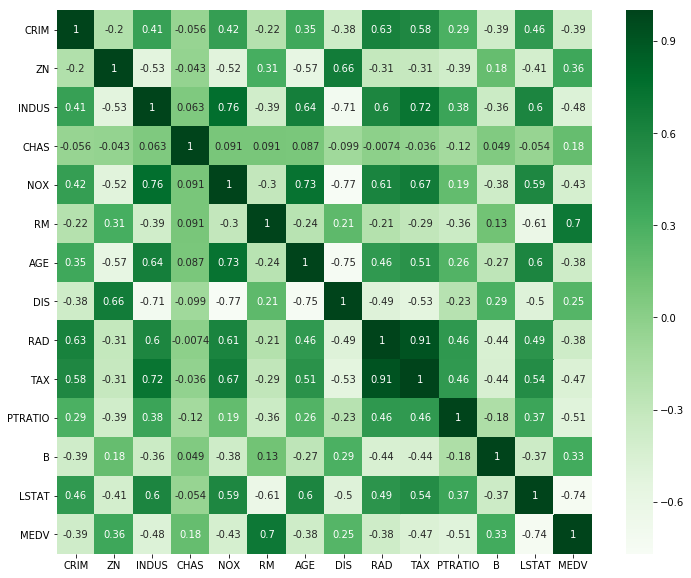

In [41]:
# Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)
plt.show()

In [18]:
# Correlation with output variable
cor_target = abs(cor["MEDV"])

# Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

RM         0.695360
PTRATIO    0.507787
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

In [20]:
print(df[["LSTAT","PTRATIO"]].corr())

            LSTAT   PTRATIO
LSTAT    1.000000  0.374044
PTRATIO  0.374044  1.000000


In [21]:
print(df[["RM","LSTAT"]].corr())

             RM     LSTAT
RM     1.000000 -0.613808
LSTAT -0.613808  1.000000


### Wrapper Method

#### Backward Elimination

In [27]:
# https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
X.sample(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
437,15.17720,0.0,18.10,0.0,0.740,6.152,100.0,1.9142,24.0,666.0,20.2,9.32,26.45
146,2.15505,0.0,19.58,0.0,0.871,5.628,100.0,1.5166,5.0,403.0,14.7,169.27,16.65
343,0.02543,55.0,3.78,0.0,0.484,6.696,56.4,5.7321,5.0,370.0,17.6,396.90,7.18


In [32]:
# Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)

# Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues

const      3.283438e-12
CRIM       1.086810e-03
ZN         7.781097e-04
INDUS      7.382881e-01
CHAS       1.925030e-03
NOX        4.245644e-06
RM         1.979441e-18
AGE        9.582293e-01
DIS        6.013491e-13
RAD        5.070529e-06
TAX        1.111637e-03
PTRATIO    1.308835e-12
B          5.728592e-04
LSTAT      7.776912e-23
dtype: float64

In [28]:
# Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

In [29]:
selected_features_BE = cols
print(selected_features_BE)

['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


#### RFE (Recursive Feature Elimination)

In [33]:
model = LinearRegression()

# Initializing RFE model
rfe = RFE(model, 7)

# Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

# Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

[False False False  True  True  True False  True  True False  True False
  True]
[2 4 3 1 1 1 7 1 1 5 1 6 1]


In [34]:
# no of features
nof_list=np.arange(1,13)            
high_score=0

# Variable to store the optimum features
nof=0           
score_list =[]

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))


Optimum number of features: 10
Score with 10 features: 0.663581


In [35]:
cols = list(X.columns)
model = LinearRegression()

# Initializing RFE model
rfe = RFE(model, 10) 

# Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

# Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO',
       'LSTAT'],
      dtype='object')


### Embedded Method

In [36]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)


Best alpha using built-in LassoCV: 0.724820
Best score using built-in LassoCV: 0.702444


/Users/mengwangk/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [37]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 10 variables and eliminated the other 3 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

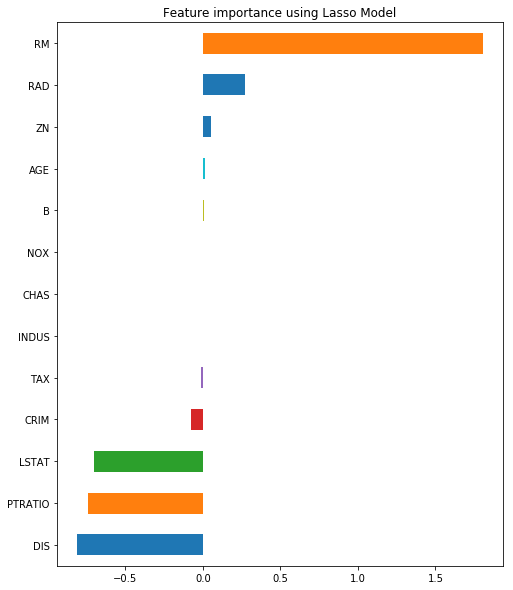

In [39]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")